# Ensemble Model Testing

This notebook tests the ensemble of CatBoost and VAE models with **fair normalized cost-based weighting**.

**Ensemble Models** (weighted combination):
- **CatBoost** (supervised): trained on 295 fraud examples
- **VAE** (unsupervised): trained on 0 fraud examples (anomaly detection)

**Comparison Model** (NOT in ensemble):
- **Logistic Regression**: Simple baseline for comparison

**Key Features**:
- Uses **cost per fraud case** for fair weighting (not raw cost)
- Accounts for training paradigm differences (supervised vs unsupervised)
- Includes LogReg baseline for performance comparison

**Prerequisites**:
- `models/catboost_best_tuned.cbm` must exist
- `models/vae_best_tuned.pth` must exist
- `models/logreg_baseline.pkl` should exist (optional)
- Data file must be available

In [1]:
# Setup path for importing from src
import sys
import os
sys.path.insert(0, os.path.abspath('../..'))

import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

from src.ensemble import FraudEnsemble

import warnings
warnings.filterwarnings('ignore')

print("Ensemble testing notebook initialized.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Ensemble testing notebook initialized.
PyTorch version: 2.8.0+cu128
CUDA available: True


## 1. Configuration

In [2]:
# Configuration
config = {
    'data_path': '../../data/processed/creditcard_fe.csv',
    'catboost_model_path': '../../models/catboost_best_tuned.cbm',
    'vae_model_path': '../../models/vae_best_tuned.pth',
    'logreg_model_path': '../../models/logreg_baseline.pkl',
    'device': 'cuda' if torch.cuda.is_available() else 'cpu',
    'C_FP': 550,  # Cost per false positive
    'C_FN': 110   # Cost per false negative
}

print("Ensemble Configuration:")
print("=" * 60)
for k, v in config.items():
    print(f"{k:25s}: {v}")

# Check if models exist
print("\nModel File Checks:")
print("=" * 60)
print(f"CatBoost exists: {os.path.exists(config['catboost_model_path'])}")
print(f"VAE exists: {os.path.exists(config['vae_model_path'])}")
print(f"LogReg exists: {os.path.exists(config['logreg_model_path'])} (optional - for comparison)")
print(f"Data exists: {os.path.exists(config['data_path'])}")

Ensemble Configuration:
data_path                : ../../data/processed/creditcard_fe.csv
catboost_model_path      : ../../models/catboost_best_tuned.cbm
vae_model_path           : ../../models/vae_best_tuned.pth
logreg_model_path        : ../../models/logreg_baseline.pkl
device                   : cuda
C_FP                     : 550
C_FN                     : 110

Model File Checks:
CatBoost exists: True
VAE exists: True
LogReg exists: True (optional - for comparison)
Data exists: True


## 2. Initialize and Run Ensemble

In [3]:
# Create ensemble instance
ensemble = FraudEnsemble(
    catboost_model_path=config['catboost_model_path'],
    vae_model_path=config['vae_model_path'],
    data_path=config['data_path'],
    C_FP=config['C_FP'],
    C_FN=config['C_FN'],
    device=config['device']
)

print("Ensemble instance created successfully.")

Ensemble instance created successfully.


In [4]:
# Run ensemble pipeline
results = ensemble.run()


FRAUD DETECTION ENSEMBLE
LOADING MODELS

[1/2] Loading CatBoost model...
  CatBoost loaded successfully
  Optimal threshold: 0.6700
  Test cost: $2,310

[2/2] Loading VAE model...
  VAE loaded successfully
  Optimal threshold: 1.649074
  Test cost: $18,700

Models loaded successfully!

LOADING DATA

Loading data from ../../data/processed/creditcard_fe.csv...

Dropping features to match training:
  Features to drop: Class, V13, V15, V19, V20, V22, V23, V24, V25, V26, Time, Amount, Hour, Hour_sin, log_Amount
  Loaded CatBoost scaler (fitted on all data)
  Loaded VAE scaler (fitted on normal transactions only)

Dataset loaded and scaled:
  Total samples: 284,807
  Features: 22 (logreg_baseline feature set)
  Normal transactions: 284,315 (99.83%)
  Fraud transactions: 492 (0.17%)

  Note: Data scaled separately for each model using their respective scalers

  ⚠️  IMPORTANT: Ensemble evaluates on FULL dataset (492 fraud)
      Individual models were trained/tested on smaller subsets:
     

In [5]:
# Extract metrics from ensemble results for easier access
catboost_metrics = results['individual_models']['catboost']
vae_metrics = results['individual_models']['vae']

print("\n" + "=" * 60)
print("EXTRACTED METRICS FOR COMPARISON")
print("=" * 60)
print(f"\nCatBoost and VAE metrics extracted from ensemble results.")
print(f"All models evaluated on FULL dataset ({ensemble.y.sum()} fraud cases, {len(ensemble.y):,} total samples)")


EXTRACTED METRICS FOR COMPARISON

CatBoost and VAE metrics extracted from ensemble results.
All models evaluated on FULL dataset (492 fraud cases, 284,807 total samples)


In [6]:
# Load Logistic Regression for comparison (evaluated on same full dataset)
import joblib
from src.evaluation import FraudEvaluationMetrics

print("\n" + "=" * 60)
print("LOADING LOGISTIC REGRESSION (FOR COMPARISON)")
print("=" * 60)

if os.path.exists(config['logreg_model_path']):
    logreg_model = joblib.load(config['logreg_model_path'])
    print(f"\nLoaded: {config['logreg_model_path']}")
    
    # IMPORTANT: Use the SAME data as ensemble for fair comparison
    df = pd.read_csv(config['data_path'])
    y_logreg = df['Class'].values
    
    # Verify same dataset as ensemble
    assert len(y_logreg) == len(ensemble.y), "LogReg data size mismatch!"
    assert (y_logreg == ensemble.y).all(), "LogReg labels mismatch!"
    
    # Prepare features (same 22 features, NO scaling for LogReg)
    drop_cols = ['Class', 'V13', 'V15', 'V19', 'V20', 'V22', 'V23', 'V24', 'V25', 'V26', 
                 'Time', 'Amount', 'Hour', 'Hour_sin', 'log_Amount']
    X_logreg = df.drop(columns=drop_cols).values
    
    print(f"Dataset: {len(X_logreg):,} samples, {X_logreg.shape[1]} features")
    print(f"Fraud cases: {y_logreg.sum()} (same as ensemble)")
    
    # Get predictions (default 0.5 threshold, NO scaling)
    logreg_preds = logreg_model.predict(X_logreg)
    logreg_probs = logreg_model.predict_proba(X_logreg)[:, 1]
    
    # Evaluate on full dataset
    evaluator = FraudEvaluationMetrics(cost_fp=config['C_FP'], cost_fn=config['C_FN'])
    logreg_metrics = evaluator.calculate_metrics(y_logreg, logreg_preds, y_scores=logreg_probs)
    
    print(f"\nLogReg Performance (Full Dataset):")
    print(f"  Precision: {logreg_metrics['precision']:.4f}, Recall: {logreg_metrics['recall']:.4f}")
    print(f"  PR-AUC: {logreg_metrics['pr_auc']:.4f}, Cost: ${logreg_metrics['total_cost']:,.0f}")
    print(f"  Note: NO threshold optimization, NO scaling")
    
    logreg_available = True
else:
    print(f"\n⚠️  LogReg model not found: {config['logreg_model_path']}")
    print("Skipping LogReg comparison.")
    logreg_available = False
    logreg_metrics = None


LOADING LOGISTIC REGRESSION (FOR COMPARISON)

Loaded: ../../models/logreg_baseline.pkl
Dataset: 284,807 samples, 22 features
Fraud cases: 492 (same as ensemble)

LogReg Performance (Full Dataset):
  Precision: 0.8857, Recall: 0.6301
  PR-AUC: 0.7568, Cost: $42,020
  Note: NO threshold optimization, NO scaling


## 3. Results Analysis

In [7]:
# Create comparison table
if logreg_available:
    comparison_df = pd.DataFrame({
        'Model': ['LogReg', 'CatBoost', 'VAE', 'Ensemble'],
        'Precision': [
            logreg_metrics['precision'],
            catboost_metrics['precision'],
            vae_metrics['precision'],
            results['precision']
        ],
        'Recall': [
            logreg_metrics['recall'],
            catboost_metrics['recall'],
            vae_metrics['recall'],
            results['recall']
        ],
        'PR-AUC': [
            logreg_metrics['pr_auc'] if logreg_metrics['pr_auc'] is not None else 0.0,
            catboost_metrics['pr_auc'] if catboost_metrics['pr_auc'] is not None else 0.0,
            vae_metrics['pr_auc'] if vae_metrics['pr_auc'] is not None else 0.0,
            results['pr_auc'] if results['pr_auc'] is not None else 0.0
        ],
        'Total Cost ($)': [
            logreg_metrics['total_cost'],
            catboost_metrics['total_cost'],
            vae_metrics['total_cost'],
            results['total_cost']
        ],
        'FP': [
            logreg_metrics['false_positives'],
            catboost_metrics['false_positives'],
            vae_metrics['false_positives'],
            results['false_positives']
        ],
        'FN': [
            logreg_metrics['false_negatives'],
            catboost_metrics['false_negatives'],
            vae_metrics['false_negatives'],
            results['false_negatives']
        ]
    })
else:
    comparison_df = pd.DataFrame({
        'Model': ['CatBoost', 'VAE', 'Ensemble'],
        'Precision': [
            catboost_metrics['precision'],
            vae_metrics['precision'],
            results['precision']
        ],
        'Recall': [
            catboost_metrics['recall'],
            vae_metrics['recall'],
            results['recall']
        ],
        'PR-AUC': [
            catboost_metrics['pr_auc'] if catboost_metrics['pr_auc'] is not None else 0.0,
            vae_metrics['pr_auc'] if vae_metrics['pr_auc'] is not None else 0.0,
            results['pr_auc'] if results['pr_auc'] is not None else 0.0
        ],
        'Total Cost ($)': [
            catboost_metrics['total_cost'],
            vae_metrics['total_cost'],
            results['total_cost']
        ],
        'FP': [
            catboost_metrics['false_positives'],
            vae_metrics['false_positives'],
            results['false_positives']
        ],
        'FN': [
            catboost_metrics['false_negatives'],
            vae_metrics['false_negatives'],
            results['false_negatives']
        ]
    })

print("\n" + "=" * 80)
print("MODEL COMPARISON TABLE")
print("=" * 80)
print(comparison_df.to_string(index=False))

# Identify best model for each metric
print("\n" + "=" * 80)
print("BEST MODEL BY METRIC")
print("=" * 80)
best_precision = comparison_df.loc[comparison_df['Precision'].idxmax(), 'Model']
best_recall = comparison_df.loc[comparison_df['Recall'].idxmax(), 'Model']
best_pr_auc = comparison_df.loc[comparison_df['PR-AUC'].idxmax(), 'Model']
best_cost = comparison_df.loc[comparison_df['Total Cost ($)'].idxmin(), 'Model']

print(f"Best Precision: {best_precision} ({comparison_df.loc[comparison_df['Precision'].idxmax(), 'Precision']:.4f})")
print(f"Best Recall: {best_recall} ({comparison_df.loc[comparison_df['Recall'].idxmax(), 'Recall']:.4f})")
print(f"Best PR-AUC: {best_pr_auc} ({comparison_df.loc[comparison_df['PR-AUC'].idxmax(), 'PR-AUC']:.4f})")
print(f"Best Cost: {best_cost} (${comparison_df.loc[comparison_df['Total Cost ($)'].idxmin(), 'Total Cost ($)']:,.0f})")


MODEL COMPARISON TABLE
   Model  Precision   Recall   PR-AUC  Total Cost ($)  FP  FN
  LogReg   0.885714 0.630081 0.756838           42020  40 182
CatBoost   0.995110 0.827236 0.905090           10450   2  85
     VAE   0.958506 0.469512 0.649720           34210  10 261
Ensemble   0.992754 0.835366 0.906085           10560   3  81

BEST MODEL BY METRIC
Best Precision: CatBoost (0.9951)
Best Recall: Ensemble (0.8354)
Best PR-AUC: Ensemble (0.9061)
Best Cost: CatBoost ($10,450)


## 4. Visualizations

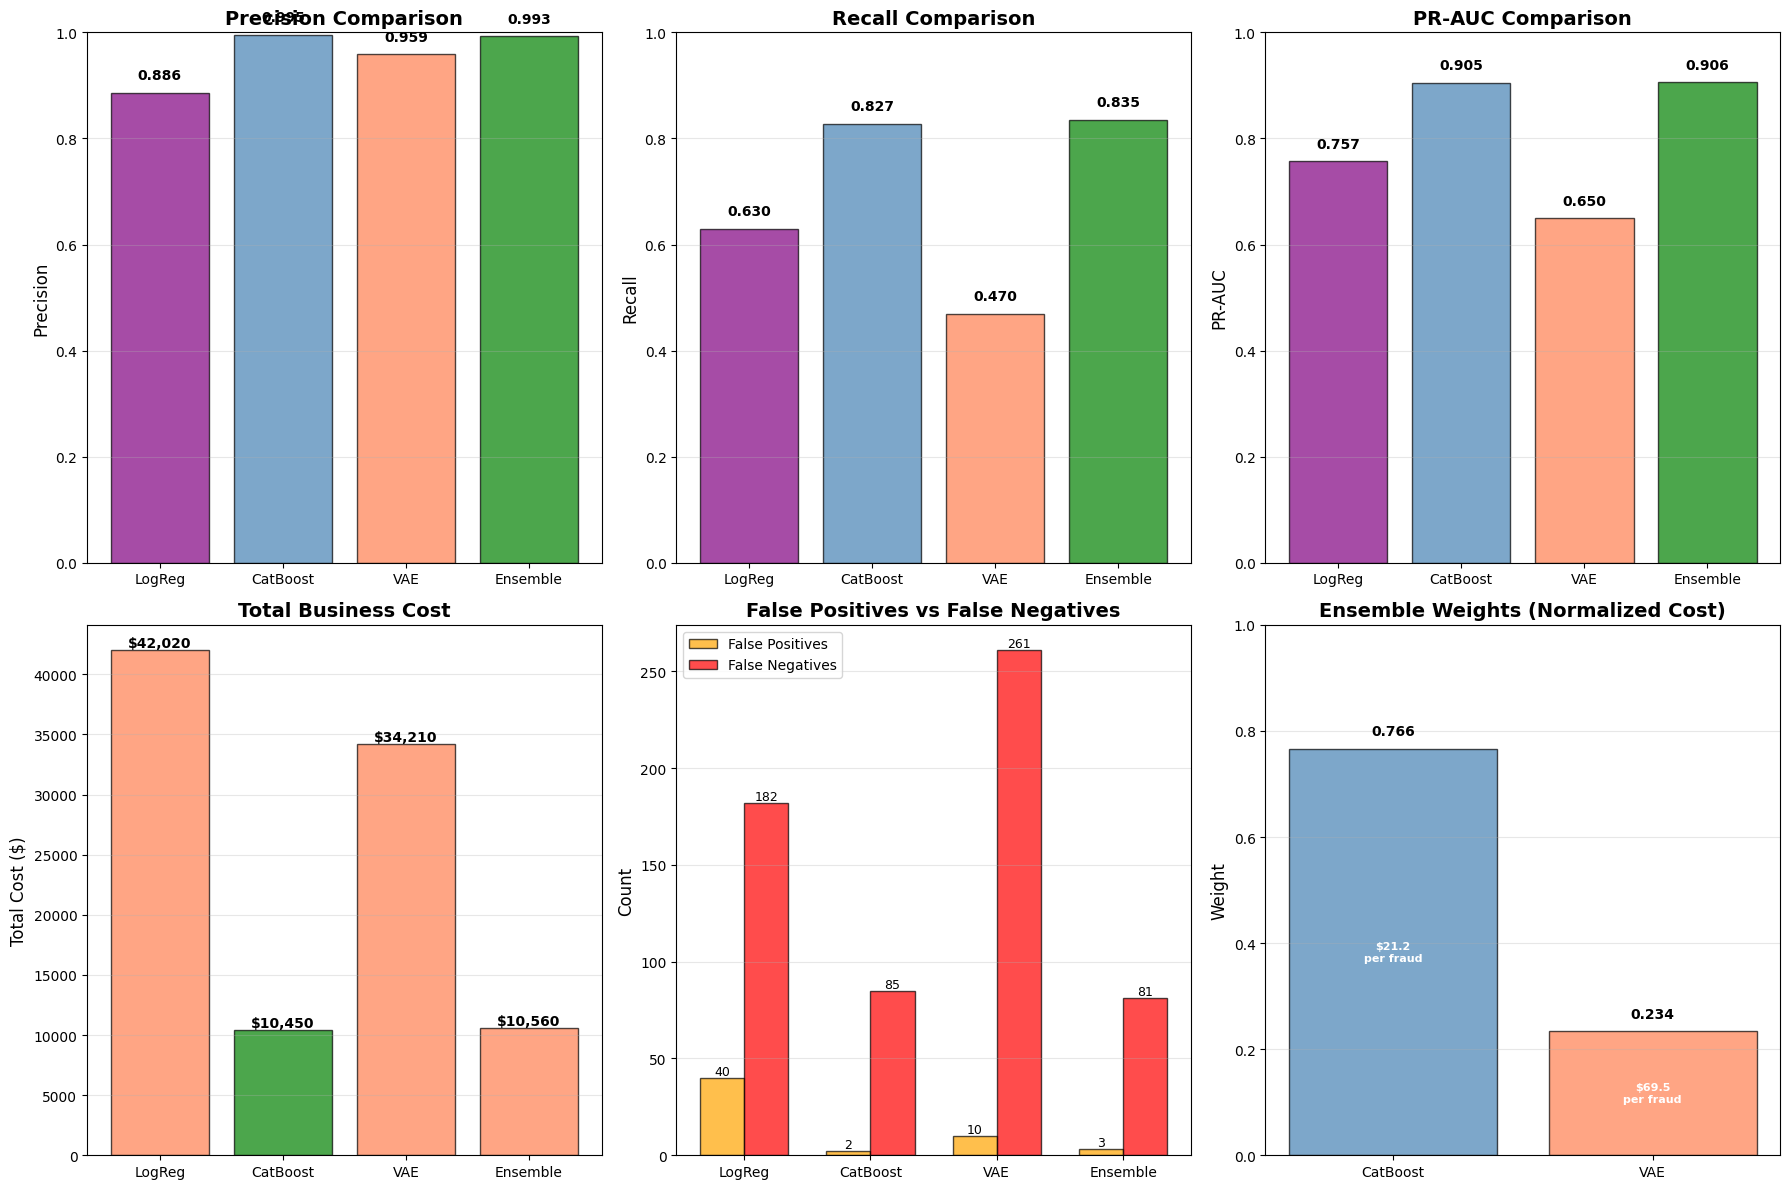


Visualization saved to: results/figures/ensemble_comparison.png


In [8]:
# Create comprehensive visualization
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Determine models and colors based on whether LogReg is available
if logreg_available:
    models = ['LogReg', 'CatBoost', 'VAE', 'Ensemble']
    colors = ['purple', 'steelblue', 'coral', 'green']
else:
    models = ['CatBoost', 'VAE', 'Ensemble']
    colors = ['steelblue', 'coral', 'green']

# 1. Precision Comparison
ax = axes[0, 0]
precision_vals = comparison_df['Precision'].values
bars = ax.bar(models, precision_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Precision', fontsize=12)
ax.set_title('Precision Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, precision_vals)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 2. Recall Comparison
ax = axes[0, 1]
recall_vals = comparison_df['Recall'].values
bars = ax.bar(models, recall_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Recall', fontsize=12)
ax.set_title('Recall Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, recall_vals)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 3. PR-AUC Comparison
ax = axes[0, 2]
pr_auc_vals = comparison_df['PR-AUC'].values
bars = ax.bar(models, pr_auc_vals, color=colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('PR-AUC', fontsize=12)
ax.set_title('PR-AUC Comparison', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, pr_auc_vals)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 4. Total Cost Comparison
ax = axes[1, 0]
cost_vals = comparison_df['Total Cost ($)'].values
cost_colors = ['green' if c == min(cost_vals) else 'coral' for c in cost_vals]
bars = ax.bar(models, cost_vals, color=cost_colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Total Cost ($)', fontsize=12)
ax.set_title('Total Business Cost', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, cost_vals)):
    ax.text(bar.get_x() + bar.get_width()/2, val, f'${val:,.0f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')

# 5. False Positives and False Negatives
ax = axes[1, 1]
fp_vals = comparison_df['FP'].values
fn_vals = comparison_df['FN'].values
x = np.arange(len(models))
width = 0.35
bars1 = ax.bar(x - width/2, fp_vals, width, label='False Positives', color='orange', alpha=0.7, edgecolor='black')
bars2 = ax.bar(x + width/2, fn_vals, width, label='False Negatives', color='red', alpha=0.7, edgecolor='black')
ax.set_ylabel('Count', fontsize=12)
ax.set_title('False Positives vs False Negatives', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend(fontsize=10)
ax.grid(True, alpha=0.3, axis='y')
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2, height, f'{int(height)}',
                ha='center', va='bottom', fontsize=9)

# 6. Model Weights in Ensemble
ax = axes[1, 2]
weight_models = ['CatBoost', 'VAE']
weight_vals = [results['weights']['catboost'], results['weights']['vae']]
weight_colors = ['steelblue', 'coral']
bars = ax.bar(weight_models, weight_vals, color=weight_colors, alpha=0.7, edgecolor='black')
ax.set_ylabel('Weight', fontsize=12)
ax.set_title('Ensemble Weights (Normalized Cost)', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1.0])
ax.grid(True, alpha=0.3, axis='y')
for i, (bar, val) in enumerate(zip(bars, weight_vals)):
    ax.text(bar.get_x() + bar.get_width()/2, val + 0.02, f'{val:.3f}', 
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Also show corresponding cost per fraud
    cost = catboost_metrics['total_cost'] if i == 0 else vae_metrics['total_cost']
    cost_per_fraud = cost / results['baseline_cost'] * config['C_FN']
    ax.text(bar.get_x() + bar.get_width()/2, val/2, f'${cost_per_fraud:.1f}\nper fraud', 
            ha='center', va='center', fontsize=8, color='white', fontweight='bold')

plt.tight_layout()
plt.savefig('../../results/figures/ensemble_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nVisualization saved to: results/figures/ensemble_comparison.png")

## 5. Cost Savings Analysis

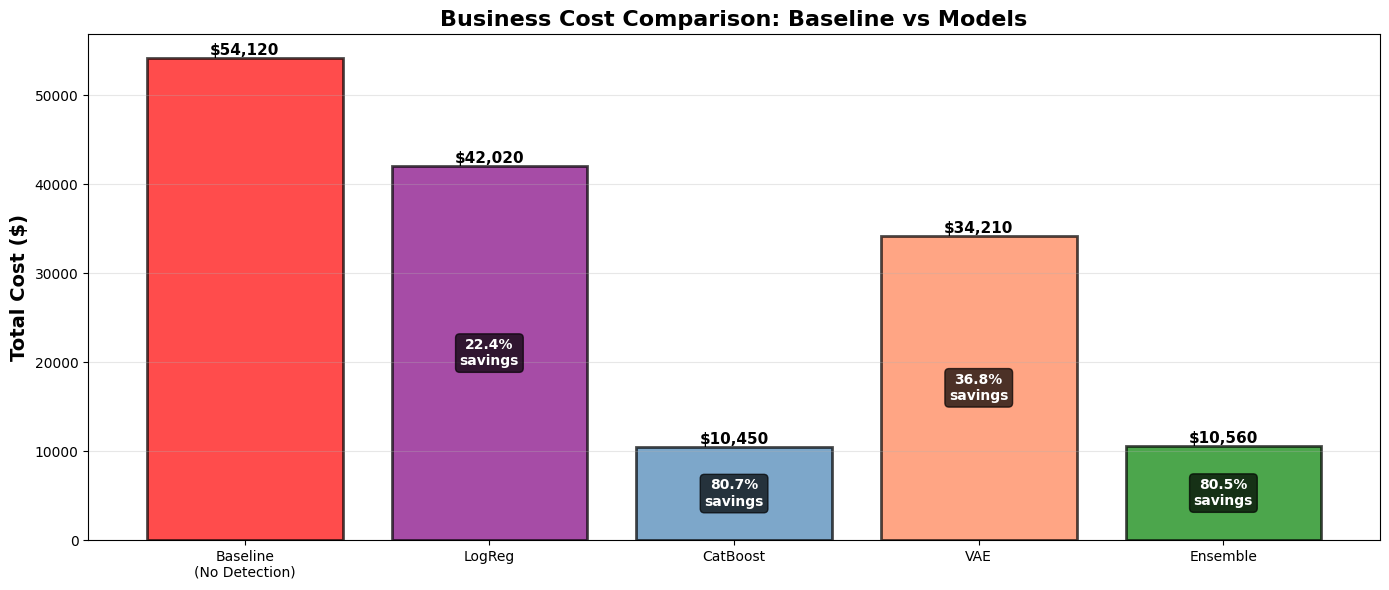


Cost savings visualization saved to: results/figures/ensemble_cost_savings.png


In [9]:
# Cost savings visualization
fig, ax = plt.subplots(1, 1, figsize=(14, 6))

baseline_cost = results['baseline_cost']

if logreg_available:
    all_models = ['Baseline\n(No Detection)', 'LogReg', 'CatBoost', 'VAE', 'Ensemble']
    all_costs = [
        baseline_cost,
        logreg_metrics['total_cost'],
        catboost_metrics['total_cost'],
        vae_metrics['total_cost'],
        results['total_cost']
    ]
    all_colors = ['red', 'purple', 'steelblue', 'coral', 'green']
else:
    all_models = ['Baseline\n(No Detection)', 'CatBoost', 'VAE', 'Ensemble']
    all_costs = [
        baseline_cost,
        catboost_metrics['total_cost'],
        vae_metrics['total_cost'],
        results['total_cost']
    ]
    all_colors = ['red', 'steelblue', 'coral', 'green']

bars = ax.bar(all_models, all_costs, color=all_colors, alpha=0.7, edgecolor='black', linewidth=2)
ax.set_ylabel('Total Cost ($)', fontsize=14, fontweight='bold')
ax.set_title('Business Cost Comparison: Baseline vs Models', fontsize=16, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

# Add cost labels on bars
for i, (bar, cost) in enumerate(zip(bars, all_costs)):
    ax.text(bar.get_x() + bar.get_width()/2, cost, f'${cost:,.0f}',
            ha='center', va='bottom', fontsize=11, fontweight='bold')
    
    # Add savings percentage for models
    if i > 0:
        savings_pct = (baseline_cost - cost) / baseline_cost * 100
        ax.text(bar.get_x() + bar.get_width()/2, cost/2, f'{savings_pct:.1f}%\nsavings',
                ha='center', va='center', fontsize=10, color='white', fontweight='bold',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='black', alpha=0.7))

plt.tight_layout()
plt.savefig('../../results/figures/ensemble_cost_savings.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nCost savings visualization saved to: results/figures/ensemble_cost_savings.png")

## 6. Save Results

In [10]:
# Save comparison table
comparison_df.to_csv('../../results/ensemble_comparison.csv', index=False)
print("Comparison table saved to: results/ensemble_comparison.csv")

# Save detailed results
detailed_results = {
    'ensemble': {
        'precision': float(results['precision']),
        'recall': float(results['recall']),
        'pr_auc': float(results['pr_auc']) if results['pr_auc'] is not None else None,
        'total_cost': float(results['total_cost']),
        'false_positives': int(results['false_positives']),
        'false_negatives': int(results['false_negatives']),
        'optimal_threshold': float(results['optimal_threshold']),
        'savings': float(results['savings']),
        'savings_percentage': float(results['savings'] / results['baseline_cost'] * 100)
    },
    'catboost': {
        'precision': float(catboost_metrics['precision']),
        'recall': float(catboost_metrics['recall']),
        'pr_auc': float(catboost_metrics['pr_auc']) if catboost_metrics['pr_auc'] is not None else None,
        'total_cost': float(catboost_metrics['total_cost']),
        'false_positives': int(catboost_metrics['false_positives']),
        'false_negatives': int(catboost_metrics['false_negatives']),
        'weight_in_ensemble': float(results['weights']['catboost'])
    },
    'vae': {
        'precision': float(vae_metrics['precision']),
        'recall': float(vae_metrics['recall']),
        'pr_auc': float(vae_metrics['pr_auc']) if vae_metrics['pr_auc'] is not None else None,
        'total_cost': float(vae_metrics['total_cost']),
        'false_positives': int(vae_metrics['false_positives']),
        'false_negatives': int(vae_metrics['false_negatives']),
        'weight_in_ensemble': float(results['weights']['vae'])
    },
    'baseline': {
        'total_cost': float(results['baseline_cost'])
    },
    'config': config
}

# Add LogReg if available
if logreg_available:
    detailed_results['logistic_regression'] = {
        'precision': float(logreg_metrics['precision']),
        'recall': float(logreg_metrics['recall']),
        'pr_auc': float(logreg_metrics['pr_auc']) if logreg_metrics['pr_auc'] is not None else None,
        'total_cost': float(logreg_metrics['total_cost']),
        'false_positives': int(logreg_metrics['false_positives']),
        'false_negatives': int(logreg_metrics['false_negatives']),
        'in_ensemble': False,
        'note': 'Comparison only - not included in ensemble'
    }

with open('../../results/ensemble_detailed_results.json', 'w') as f:
    json.dump(detailed_results, f, indent=2)

print("Detailed results saved to: results/ensemble_detailed_results.json")

Comparison table saved to: results/ensemble_comparison.csv
Detailed results saved to: results/ensemble_detailed_results.json


## 8. Summary Report

In [11]:
print("\n" + "=" * 80)
print("ENSEMBLE TESTING COMPLETE - FINAL SUMMARY")
print("=" * 80)

print("\n📊 MODEL PERFORMANCE RANKING (by Total Cost):")
ranked = comparison_df.sort_values('Total Cost ($)')
for i, row in enumerate(ranked.iterrows(), 1):
    idx, data = row
    print(f"\n{i}. {data['Model']}")
    print(f"   Total Cost: ${data['Total Cost ($)']:,.0f}")
    print(f"   Precision: {data['Precision']:.4f}, Recall: {data['Recall']:.4f}, PR-AUC: {data['PR-AUC']:.4f}")
    print(f"   FP: {data['FP']}, FN: {data['FN']}")
    savings_pct = (baseline_cost - data['Total Cost ($)']) / baseline_cost * 100
    print(f"   Savings vs Baseline: ${baseline_cost - data['Total Cost ($)']:,.0f} ({savings_pct:.2f}%)")

print("\n" + "=" * 80)
print("🎯 KEY INSIGHTS:")
print("=" * 80)

best_model = ranked.iloc[0]['Model']
best_cost = ranked.iloc[0]['Total Cost ($)']

print(f"\n1. BEST MODEL: {best_model} with ${best_cost:,.0f} total cost")
print(f"\n2. ENSEMBLE WEIGHTS:")
print(f"   - CatBoost receives {results['weights']['catboost']:.1%} weight (cost: ${catboost_metrics['total_cost']:,.0f})")
print(f"   - VAE receives {results['weights']['vae']:.1%} weight (cost: ${vae_metrics['total_cost']:,.0f})")

if results['weights']['catboost'] > results['weights']['vae']:
    print(f"   → CatBoost has higher weight due to lower cost")
else:
    print(f"   → VAE has higher weight due to lower cost")

print(f"\n3. COST REDUCTION FROM BASELINE:")
print(f"   - Baseline (no detection): ${baseline_cost:,.0f}")
print(f"   - Best model saves: ${baseline_cost - best_cost:,.0f} ({(baseline_cost - best_cost)/baseline_cost*100:.2f}%)")

print(f"\n4. ENSEMBLE PERFORMANCE:")
if results['total_cost'] <= catboost_metrics['total_cost'] and results['total_cost'] <= vae_metrics['total_cost']:
    print(f"   ✓ Ensemble achieves BEST cost (${results['total_cost']:,.0f})")
elif results['total_cost'] <= max(catboost_metrics['total_cost'], vae_metrics['total_cost']):
    print(f"   ≈ Ensemble is competitive (${results['total_cost']:,.0f})")
else:
    print(f"   ✗ Individual models outperform ensemble")

print("\n" + "=" * 80)
print("📁 Output files saved:")
print("   - results/figures/ensemble_comparison.png")
print("   - results/figures/ensemble_cost_savings.png")
print("   - results/ensemble_comparison.csv")
print("   - results/ensemble_detailed_results.json")
print("   - results/ensemble_results.json")
print("=" * 80)


ENSEMBLE TESTING COMPLETE - FINAL SUMMARY

📊 MODEL PERFORMANCE RANKING (by Total Cost):

1. CatBoost
   Total Cost: $10,450
   Precision: 0.9951, Recall: 0.8272, PR-AUC: 0.9051
   FP: 2, FN: 85
   Savings vs Baseline: $43,670 (80.69%)

2. Ensemble
   Total Cost: $10,560
   Precision: 0.9928, Recall: 0.8354, PR-AUC: 0.9061
   FP: 3, FN: 81
   Savings vs Baseline: $43,560 (80.49%)

3. VAE
   Total Cost: $34,210
   Precision: 0.9585, Recall: 0.4695, PR-AUC: 0.6497
   FP: 10, FN: 261
   Savings vs Baseline: $19,910 (36.79%)

4. LogReg
   Total Cost: $42,020
   Precision: 0.8857, Recall: 0.6301, PR-AUC: 0.7568
   FP: 40, FN: 182
   Savings vs Baseline: $12,100 (22.36%)

🎯 KEY INSIGHTS:

1. BEST MODEL: CatBoost with $10,450 total cost

2. ENSEMBLE WEIGHTS:
   - CatBoost receives 76.6% weight (cost: $10,450)
   - VAE receives 23.4% weight (cost: $34,210)
   → CatBoost has higher weight due to lower cost

3. COST REDUCTION FROM BASELINE:
   - Baseline (no detection): $54,120
   - Best model s